In [8]:
import matplotlib.pyplot as plt
import pandas as pd

from src.etl.utils import download_data_from_uciml, load_data

In [15]:
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

In [9]:
download_data_from_uciml(id=544)
X, y = load_data()

In [10]:
print(X.shape, y.shape)

(2111, 16) (2111,)


In [11]:
X.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

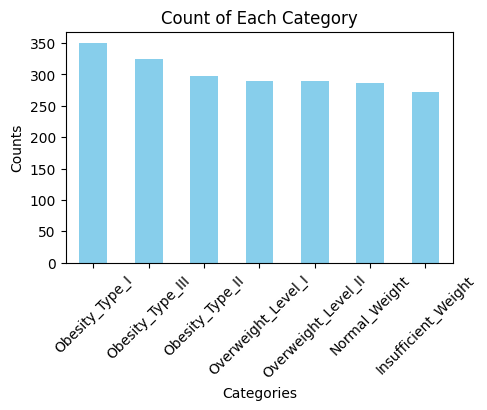

In [12]:
plot_df = y.value_counts()

plt.figure(figsize=(5, 3))
plot_df.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Count of Each Category')
plt.xticks(rotation=45)
plt.show()

In [13]:
import ast
[print(f"Missing data for {data}: \n {globals()[data].isna().sum()}") for data in ["y", "X"]]

Missing data for y: 
 0
Missing data for X: 
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


[None, None]

In [124]:
X.shape

(2111, 16)

In [137]:
threshold = .01

X_filtered = X.copy()
y_filtered = y.copy()
for col in list(X_filtered.select_dtypes(include=['object']).columns):
    count_col = X_filtered[col].value_counts(normalize=True)
    print(count_col[count_col < .01])
    # Filter out rare classes
    rare_indices = X_filtered.index[X_filtered[col].isin(count_col[count_col < threshold].index)].tolist()
    X_filtered = X_filtered.drop(rare_indices)
    y_filtered = pd.Series([y_filtered[i] for i in range(len(y_filtered)) if i not in rare_indices])

Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
Series([], Name: proportion, dtype: float64)
CALC
Always    0.000474
Name: proportion, dtype: float64
MTRANS
Motorbike    0.005213
Bike         0.003318
Name: proportion, dtype: float64


In [138]:
X_filtered.shape

(2092, 16)

In [155]:
y_filtered.shape

(2092,)

In [142]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold

In [144]:
def preprocess_data(X_train, X_test):
    """
    Preprocess the dataset: Encode categorical variables, normalize numerical variables, and convert to PyTorch tensors.

    Parameters:
    X_train (DataFrame): The feature train set.
    X_test (DataFrame): The feature test set.

    
    Returns:
    X_train (DataFrame): The preprocessed train features
    X_test (DataFrame): The preprocessed test features
    """
    categorical_features = X_train.select_dtypes(include=['object']).columns
    numeric_features = X_train.select_dtypes(include=['float64']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)])

    # Fit on training data and transform both training and test data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test

In [145]:
def train_validate_model(model, criterion, optimizer, train_loader, val_loader, epochs: int):
    """
    Train and validate the PyTorch model, returning the history of training and validation losses.

    Parameters:
    model (torch.nn.Module): The model to be trained and validated
    criterion (Callable): Loss function
    optimizer (torch.optim.Optimizer): Optimizer
    train_loader (DataLoader): DataLoader for the training set
    val_loader (DataLoader): DataLoader for the validation set
    epochs (int): Number of training epochs

    Returns:
    Tuple[List[float], List[float]]: Lists of average training and validation losses per epoch
    """
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses


def evaluate_model(model, test_loader):
    """
    Evaluate the PyTorch model.

    Parameters:
    model: The PyTorch model to be evaluated
    test_loader: DataLoader for the test set

    Returns:
    accuracy (float): The accuracy of the model on the test set
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [146]:
from typing import Callable, List

def perform_cross_validation(model_factory: Callable[[int, int], torch.nn.Module], 
                             optimizer_factory: Callable[[torch.nn.Module], torch.optim.Optimizer],
                             X: torch.Tensor, 
                             y: torch.Tensor, 
                             k_folds: int,
                             epochs: int) -> List[float]:
    """
    Perform k-fold cross-validation and return average test accuracy, training losses, and validation losses.

    Parameters:
    model_factory (Callable[[int, int], torch.nn.Module]): Factory function to create a new instance of the model
    optimizer_factory (Callable[[torch.nn.Module], torch.optim.Optimizer]): Factory function to create a new optimizer
    X (torch.Tensor): The features
    y (torch.Tensor): The target variable
    k_folds (int): Number of folds in cross-validation

    Returns:
    Tuple[float, List[List[float]], List[List[float]]]: Average accuracy, training losses, test losses
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    all_train_losses, all_test_losses = [], []

    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        # Split data for the fold
        X_train_fold, X_test_fold = X.iloc[train_ids], X.iloc[test_ids]
        y_train_fold, y_test_fold = y[train_ids], y[test_ids]

        # Preprocess the data for the current fold
        X_train_fold, X_test_fold = preprocess_data(X_train_fold, X_test_fold)
        y_train_fold = pd.get_dummies(y_train_fold).values
        y_test_fold = pd.get_dummies(y_test_fold).values

        # Convert to tensors
        X_train_fold, y_train_fold = [torch.tensor(z, dtype=torch.float32) for z in [X_train_fold, y_train_fold]]
        X_test_fold, y_test_fold = [torch.tensor(z, dtype=torch.float32) for z in [X_test_fold, y_test_fold]]

        # DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold), batch_size=32)
        
        
        
        # Determine input and output sizes
        input_size = X_train_fold.shape[1]
        output_size = y_train_fold.shape[1] # assuming y_train is one-hot encoded

        # Initialize model for the current fold
        model = model_factory(input_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_factory(model)
            
        train_losses, test_losses = train_validate_model(model, criterion, optimizer, train_loader, test_loader, epochs)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)

        fold_accuracy = evaluate_model(model, test_loader)
        print(f'Fold {fold+1}, Accuracy: {fold_accuracy}%')
        fold_accuracies.append(fold_accuracy)
        
    avg_accuracy = np.mean(fold_accuracies)
    return avg_accuracy, all_train_losses, all_test_losses

In [147]:
def plot_train_val_losses(train_losses, val_losses, opti: str, model: str, save: bool = False):
    """
    Plot the training and validation loss curves.

    Parameters:
    train_losses (List[List[float]]): Training losses for each fold
    val_losses (List[List[float]]): Validation losses for each fold
    """
    avg_train_losses = np.mean(train_losses, axis=0)
    avg_val_losses = np.mean(val_losses, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_losses, label='Average Training Loss')
    plt.plot(avg_val_losses, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves for {model} with {opti} optimizer')
    plt.legend()
    if save:
        plt.savefig(f'../assets/img/curves_{model}_{opti.lower()}.png')
    plt.show()

In [148]:
adam_grid = {
    'lr': [0.001, 0.0005, 0.0001, 0.00005],
    'betas': [(0.9, 0.999), (0.95, 0.999), (0.85, 0.995)]
}

sgd_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005],
    'momentum': [0.95, 0.9, 0.8],
    'nesterov': [True]
}

adagrad_grid = {
    'lr': [0.01, 0.005, 0.001, 0.0005]
}

rmsprop_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'alpha': [0.99, 0.9],
    'momentum': [0.95, 0.9, 0.8]
}

In [149]:
from itertools import product

def grid_search_optimizer(model_factory, optimizer_factory, param_grid, X, y, k_folds=5, epochs=70):
    best_accuracy = 0
    best_params = None

    for params in product(*param_grid.values()):
        # Set the parameters for the optimizer
        optimizer_params = dict(zip(param_grid.keys(), params))
        optimizer = lambda model: optimizer_factory(model, **optimizer_params)

        # Perform cross-validation
        avg_accuracy, _, _ = perform_cross_validation(model_factory, optimizer, X, y, k_folds, epochs)

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = optimizer_params

        print(f"Params: {optimizer_params}, Accuracy: {avg_accuracy:.2f}%")

    return best_params, best_accuracy

def adam_factory(model, lr, betas):
    return optim.Adam(model.parameters(), lr=lr, betas=betas)

def sgd_nesterov_factory(model, lr, momentum, nesterov=True):
    return optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

def adagrad_factory(model, lr):
    return optim.Adagrad(model.parameters(), lr=lr)

def rmsprop_factory(model, lr, alpha, momentum):
    return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, momentum=momentum)

In [150]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return out
    
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ComplexNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x) # no need to include sigmoid function bc we are using nn.CrossEntropyLoss()
        return x
    
logistic_regression_factory = lambda input_size, output_size: LogisticRegression(input_size, output_size)
simple_nn_factory = lambda input_size, output_size: SimpleNN(input_size, output_size)
complex_nn_factory = lambda input_size, output_size: ComplexNN(input_size, output_size)

models = {
    'Logistic Regression': logistic_regression_factory,
    'Simple Neural Network': simple_nn_factory,
    'Complex Neural Network': complex_nn_factory
}

In [151]:
import matplotlib.pyplot as plt
import numpy as np

def plot_optimizer_losses(model_name, optimizer_losses, save=False):
    """
    Plot the training and validation loss curves for different optimizers side by side.

    Parameters:
    model_name (str): Name of the model
    optimizer_losses (dict): A dictionary where keys are optimizer names and values are tuples of (train_losses, val_losses)
    save (bool): Whether to save the plot
    """
    num_optimizers = len(optimizer_losses)
    fig, axes = plt.subplots(1, num_optimizers, figsize=(num_optimizers * 6, 5), sharey=True)

    for idx, (opti, (train_losses, val_losses)) in enumerate(optimizer_losses.items()):
        avg_train_losses = np.mean(train_losses, axis=0)
        avg_val_losses = np.mean(val_losses, axis=0)

        ax = axes[idx]
        ax.plot(avg_train_losses, label='Average Training Loss')
        ax.plot(avg_val_losses, label='Average Validation Loss')
        ax.set_title(f'{opti} Optimizer')
        ax.set_xlabel('Epochs')
        if idx == 0:
            ax.set_ylabel('Loss')
        ax.legend()

    plt.suptitle(f'')
    
    if save:
        plt.savefig(f'../assets/img/loss_curves_{model_name.lower().replace(" ", "_")}.png')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Logistic Regression with Adam
Fold 1, Accuracy: 77.56563245823389%
Fold 2, Accuracy: 74.22434367541766%
Fold 3, Accuracy: 74.64114832535886%
Fold 4, Accuracy: 77.03349282296651%
Fold 5, Accuracy: 79.66507177033493%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 76.63%
Fold 1, Accuracy: 77.80429594272077%
Fold 2, Accuracy: 74.22434367541766%
Fold 3, Accuracy: 75.83732057416267%
Fold 4, Accuracy: 76.79425837320574%
Fold 5, Accuracy: 80.622009569378%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 77.06%
Fold 1, Accuracy: 78.28162291169451%
Fold 2, Accuracy: 75.6563245823389%
Fold 3, Accuracy: 77.27272727272727%
Fold 4, Accuracy: 77.7511961722488%
Fold 5, Accuracy: 80.38277511961722%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 77.87%
Fold 1, Accuracy: 72.31503579952268%
Fold 2, Accuracy: 69.92840095465394%
Fold 3, Accuracy: 69.61722488038278%
Fold 4, Accuracy: 70.33492822966507%
Fold 5, Accuracy: 77.7511961722488%
Params: {'lr': 0.00

 25%|██▌       | 1/4 [02:41<08:04, 161.62s/it]

Fold 10, Accuracy: 82.29665071770334%
Average Cross-Validation Accuracy: 78.92%

Running grid search for Logistic Regression with SGD_Nesterov
Fold 1, Accuracy: 86.63484486873509%
Fold 2, Accuracy: 89.49880668257757%
Fold 3, Accuracy: 89.95215311004785%
Fold 4, Accuracy: 90.66985645933015%
Fold 5, Accuracy: 88.51674641148325%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 89.05%
Fold 1, Accuracy: 84.00954653937947%
Fold 2, Accuracy: 85.68019093078759%
Fold 3, Accuracy: 86.60287081339713%
Fold 4, Accuracy: 87.79904306220095%
Fold 5, Accuracy: 87.5598086124402%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 86.33%
Fold 1, Accuracy: 82.81622911694511%
Fold 2, Accuracy: 81.86157517899761%
Fold 3, Accuracy: 81.57894736842105%
Fold 4, Accuracy: 83.97129186602871%
Fold 5, Accuracy: 84.44976076555024%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 82.94%
Fold 1, Accuracy: 84.48687350835323%
Fold 2, Accuracy: 85.20286396181385%
Fold 3

 50%|█████     | 2/4 [05:10<05:07, 153.94s/it]

Fold 10, Accuracy: 89.95215311004785%
Average Cross-Validation Accuracy: 89.2%

Running grid search for Logistic Regression with AdaGrad
Fold 1, Accuracy: 65.63245823389022%
Fold 2, Accuracy: 65.63245823389022%
Fold 3, Accuracy: 66.7464114832536%
Fold 4, Accuracy: 66.26794258373205%
Fold 5, Accuracy: 68.18181818181819%
Params: {'lr': 0.01}, Accuracy: 66.49%
Fold 1, Accuracy: 63.48448687350835%
Fold 2, Accuracy: 62.29116945107398%
Fold 3, Accuracy: 62.67942583732057%
Fold 4, Accuracy: 61.72248803827751%
Fold 5, Accuracy: 64.35406698564593%
Params: {'lr': 0.005}, Accuracy: 62.91%
Fold 1, Accuracy: 44.39140811455847%
Fold 2, Accuracy: 41.050119331742245%
Fold 3, Accuracy: 46.65071770334928%
Fold 4, Accuracy: 39.473684210526315%
Fold 5, Accuracy: 38.995215311004785%
Params: {'lr': 0.001}, Accuracy: 42.11%
Fold 1, Accuracy: 32.93556085918854%
Fold 2, Accuracy: 36.9928400954654%
Fold 3, Accuracy: 36.36363636363637%
Fold 4, Accuracy: 24.641148325358852%
Fold 5, Accuracy: 40.430622009569376%
P

 75%|███████▌  | 3/4 [06:16<01:53, 113.80s/it]

Fold 10, Accuracy: 68.42105263157895%
Average Cross-Validation Accuracy: 66.54%

Running grid search for Logistic Regression with RMSProp
Fold 1, Accuracy: 90.21479713603819%
Fold 2, Accuracy: 94.03341288782816%
Fold 3, Accuracy: 93.54066985645933%
Fold 4, Accuracy: 90.9090909090909%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 92.64%
Fold 1, Accuracy: 91.8854415274463%
Fold 2, Accuracy: 94.03341288782816%
Fold 3, Accuracy: 93.30143540669856%
Fold 4, Accuracy: 94.25837320574162%
Fold 5, Accuracy: 94.97607655502392%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 93.69%
Fold 1, Accuracy: 91.16945107398568%
Fold 2, Accuracy: 92.36276849642005%
Fold 3, Accuracy: 93.54066985645933%
Fold 4, Accuracy: 94.25837320574162%
Fold 5, Accuracy: 94.01913875598086%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 93.07%
Fold 1, Accuracy: 89.49880668257757%
Fold 2, Accuracy: 93.07875894988067%
Fold 3, Accuracy: 94.

100%|██████████| 4/4 [09:56<00:00, 149.20s/it]

Fold 10, Accuracy: 96.17224880382776%
Average Cross-Validation Accuracy: 92.55%


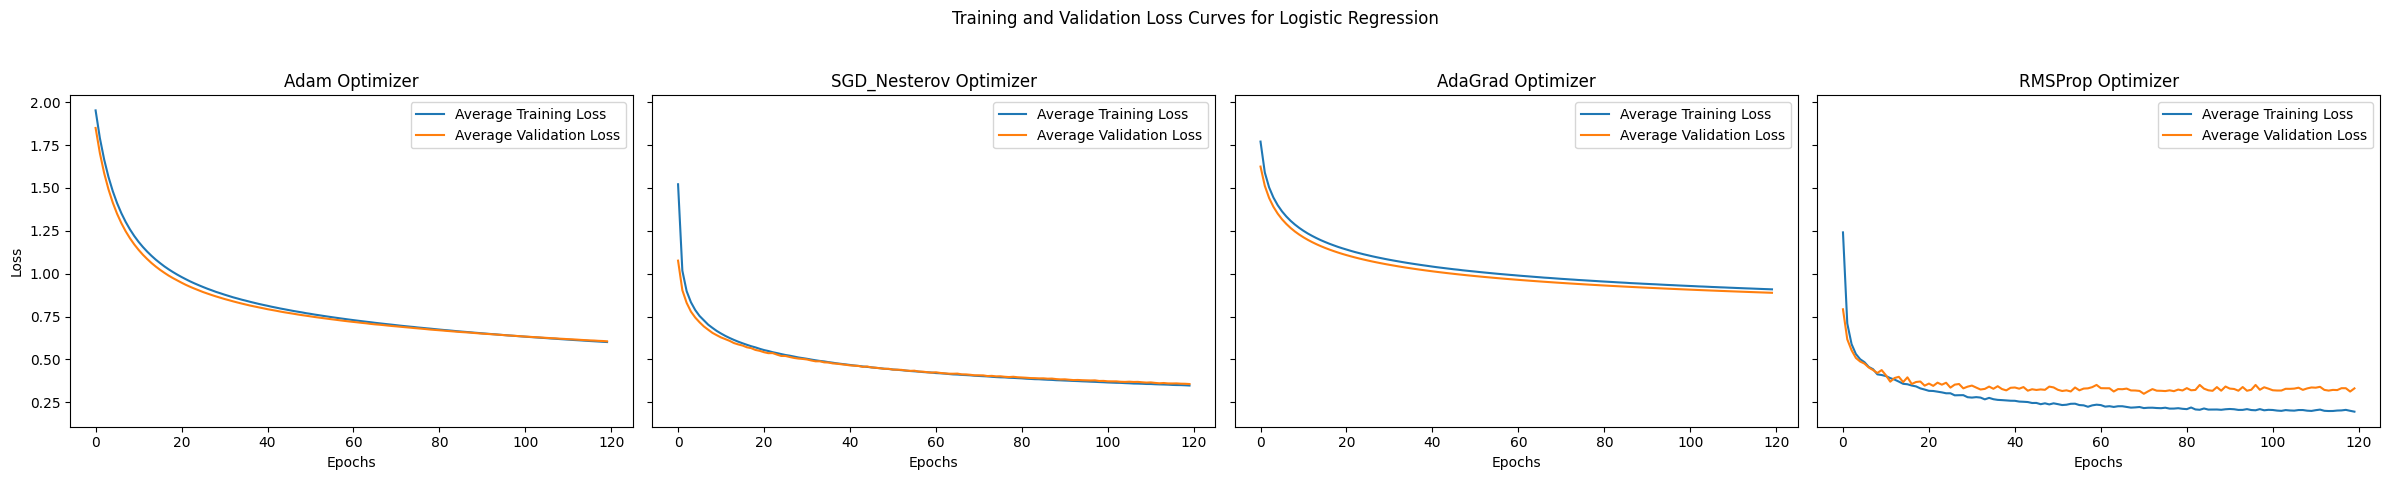

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Simple Neural Network with Adam
Fold 1, Accuracy: 93.79474940334129%
Fold 2, Accuracy: 93.07875894988067%
Fold 3, Accuracy: 94.49760765550239%
Fold 4, Accuracy: 96.65071770334929%
Fold 5, Accuracy: 93.54066985645933%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 94.31%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 94.27207637231504%
Fold 3, Accuracy: 94.01913875598086%
Fold 4, Accuracy: 97.60765550239235%
Fold 5, Accuracy: 94.25837320574162%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 94.89%
Fold 1, Accuracy: 94.5107398568019%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 96.88995215311004%
Fold 5, Accuracy: 94.01913875598086%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 94.98%
Fold 1, Accuracy: 93.79474940334129%
Fold 2, Accuracy: 93.79474940334129%
Fold 3, Accuracy: 94.49760765550239%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 93.77990430622009%
Params: {'lr'

 25%|██▌       | 1/4 [03:22<10:08, 202.77s/it]

Fold 10, Accuracy: 92.3444976076555%
Average Cross-Validation Accuracy: 94.79%

Running grid search for Simple Neural Network with SGD_Nesterov
Fold 1, Accuracy: 94.5107398568019%
Fold 2, Accuracy: 94.03341288782816%
Fold 3, Accuracy: 94.25837320574162%
Fold 4, Accuracy: 96.17224880382776%
Fold 5, Accuracy: 95.45454545454545%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 94.89%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 94.73684210526316%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 95.2153110047847%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 95.17%
Fold 1, Accuracy: 94.74940334128878%
Fold 2, Accuracy: 94.5107398568019%
Fold 3, Accuracy: 95.45454545454545%
Fold 4, Accuracy: 96.88995215311004%
Fold 5, Accuracy: 95.69377990430623%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 95.46%
Fold 1, Accuracy: 94.5107398568019%
Fold 2, Accuracy: 93.79474940334129%
Fold 3, 

 50%|█████     | 2/4 [06:21<06:17, 188.80s/it]

Fold 10, Accuracy: 96.17224880382776%
Average Cross-Validation Accuracy: 95.75%

Running grid search for Simple Neural Network with AdaGrad
Fold 1, Accuracy: 91.16945107398568%
Fold 2, Accuracy: 93.07875894988067%
Fold 3, Accuracy: 92.3444976076555%
Fold 4, Accuracy: 93.30143540669856%
Fold 5, Accuracy: 93.0622009569378%
Params: {'lr': 0.01}, Accuracy: 92.59%
Fold 1, Accuracy: 84.48687350835323%
Fold 2, Accuracy: 86.87350835322195%
Fold 3, Accuracy: 85.64593301435407%
Fold 4, Accuracy: 87.5598086124402%
Fold 5, Accuracy: 87.79904306220095%
Params: {'lr': 0.005}, Accuracy: 86.47%
Fold 1, Accuracy: 66.5871121718377%
Fold 2, Accuracy: 61.097852028639615%
Fold 3, Accuracy: 65.31100478468899%
Fold 4, Accuracy: 64.35406698564593%
Fold 5, Accuracy: 66.98564593301435%
Params: {'lr': 0.001}, Accuracy: 64.87%
Fold 1, Accuracy: 53.46062052505967%
Fold 2, Accuracy: 50.35799522673031%
Fold 3, Accuracy: 56.45933014354067%
Fold 4, Accuracy: 50.95693779904306%
Fold 5, Accuracy: 56.45933014354067%
Para

 75%|███████▌  | 3/4 [07:42<02:19, 139.28s/it]

Fold 10, Accuracy: 91.38755980861244%
Average Cross-Validation Accuracy: 92.02%

Running grid search for Simple Neural Network with RMSProp
Fold 1, Accuracy: 88.54415274463007%
Fold 2, Accuracy: 90.45346062052506%
Fold 3, Accuracy: 92.10526315789474%
Fold 4, Accuracy: 92.10526315789474%
Fold 5, Accuracy: 87.79904306220095%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 90.20%
Fold 1, Accuracy: 89.73747016706444%
Fold 2, Accuracy: 95.94272076372314%
Fold 3, Accuracy: 90.19138755980862%
Fold 4, Accuracy: 94.49760765550239%
Fold 5, Accuracy: 92.58373205741627%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 92.59%
Fold 1, Accuracy: 91.64677804295943%
Fold 2, Accuracy: 93.07875894988067%
Fold 3, Accuracy: 92.3444976076555%
Fold 4, Accuracy: 92.82296650717703%
Fold 5, Accuracy: 93.54066985645933%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 92.69%
Fold 1, Accuracy: 90.69212410501193%
Fold 2, Accuracy: 93.55608591885442%
Fold 3, Accuracy: 

100%|██████████| 4/4 [12:14<00:00, 183.61s/it]

Fold 10, Accuracy: 95.69377990430623%
Average Cross-Validation Accuracy: 95.41%


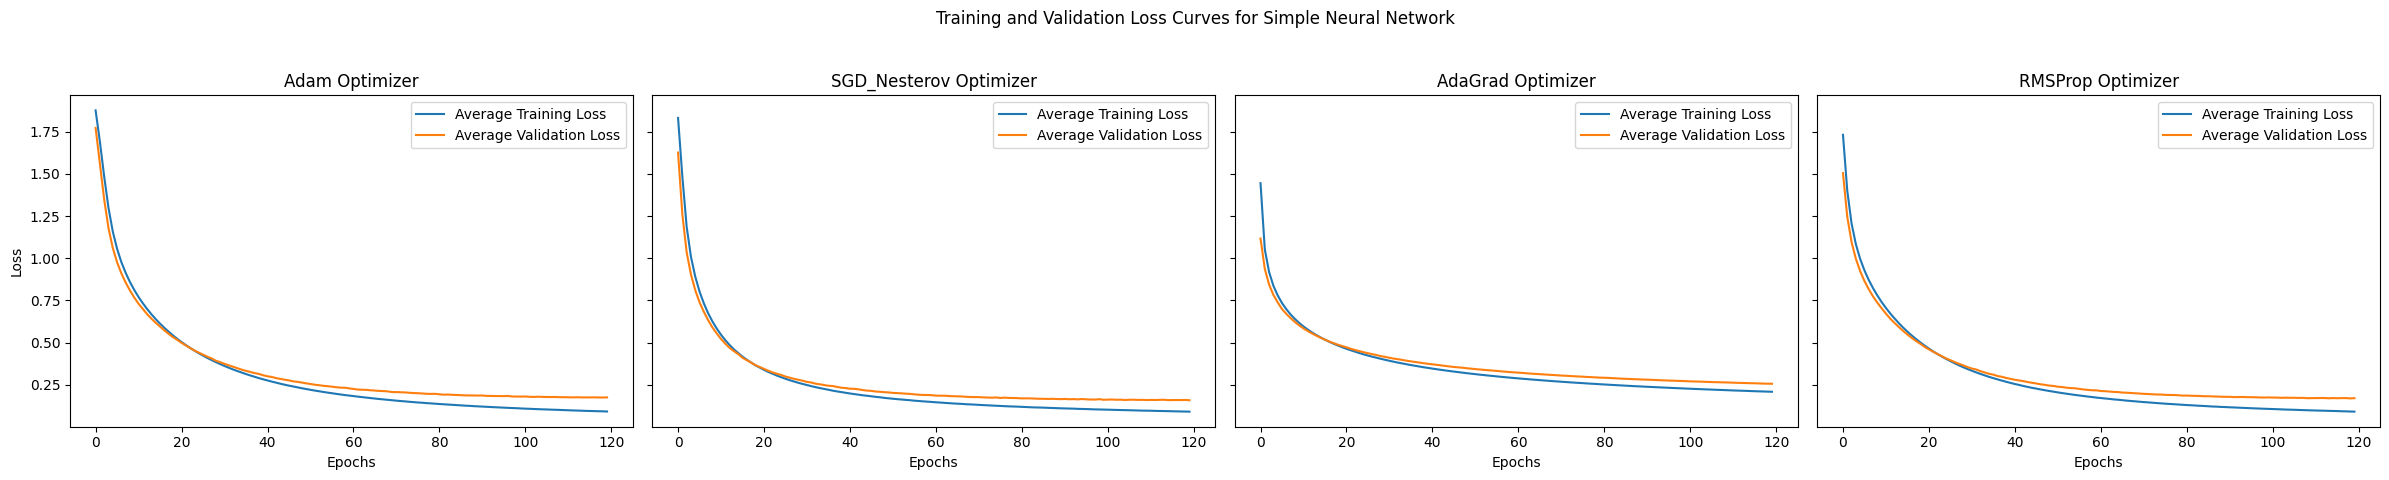

  0%|          | 0/4 [00:00<?, ?it/s]


Running grid search for Complex Neural Network with Adam
Fold 1, Accuracy: 94.98806682577566%
Fold 2, Accuracy: 94.74940334128878%
Fold 3, Accuracy: 95.45454545454545%
Fold 4, Accuracy: 96.17224880382776%
Fold 5, Accuracy: 96.17224880382776%
Params: {'lr': 0.001, 'betas': (0.9, 0.999)}, Accuracy: 95.51%
Fold 1, Accuracy: 94.5107398568019%
Fold 2, Accuracy: 94.98806682577566%
Fold 3, Accuracy: 96.17224880382776%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 96.17224880382776%
Params: {'lr': 0.001, 'betas': (0.95, 0.999)}, Accuracy: 95.65%
Fold 1, Accuracy: 94.74940334128878%
Fold 2, Accuracy: 94.5107398568019%
Fold 3, Accuracy: 95.93301435406698%
Fold 4, Accuracy: 97.12918660287082%
Fold 5, Accuracy: 95.2153110047847%
Params: {'lr': 0.001, 'betas': (0.85, 0.995)}, Accuracy: 95.51%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 94.97607655502392%
Fold 4, Accuracy: 96.65071770334929%
Fold 5, Accuracy: 95.45454545454545%
Params: {'lr':

 25%|██▌       | 1/4 [05:13<15:39, 313.09s/it]

Fold 10, Accuracy: 96.17224880382776%
Average Cross-Validation Accuracy: 95.99%

Running grid search for Complex Neural Network with SGD_Nesterov
Fold 1, Accuracy: 95.22673031026252%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 95.2153110047847%
Fold 4, Accuracy: 95.93301435406698%
Fold 5, Accuracy: 95.93301435406698%
Params: {'lr': 0.01, 'momentum': 0.95, 'nesterov': True}, Accuracy: 95.51%
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 95.22673031026252%
Fold 3, Accuracy: 95.2153110047847%
Fold 4, Accuracy: 95.69377990430623%
Fold 5, Accuracy: 95.2153110047847%
Params: {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}, Accuracy: 95.12%
Fold 1, Accuracy: 94.5107398568019%
Fold 2, Accuracy: 94.74940334128878%
Fold 3, Accuracy: 95.45454545454545%
Fold 4, Accuracy: 97.36842105263158%
Fold 5, Accuracy: 94.49760765550239%
Params: {'lr': 0.01, 'momentum': 0.8, 'nesterov': True}, Accuracy: 95.32%
Fold 1, Accuracy: 93.55608591885442%
Fold 2, Accuracy: 93.31742243436754%
Fold 3

 50%|█████     | 2/4 [09:23<09:11, 275.96s/it]

Fold 10, Accuracy: 95.2153110047847%
Average Cross-Validation Accuracy: 95.41%

Running grid search for Complex Neural Network with AdaGrad
Fold 1, Accuracy: 94.27207637231504%
Fold 2, Accuracy: 94.74940334128878%
Fold 3, Accuracy: 94.73684210526316%
Fold 4, Accuracy: 96.41148325358851%
Fold 5, Accuracy: 93.30143540669856%
Params: {'lr': 0.01}, Accuracy: 94.69%
Fold 1, Accuracy: 92.60143198090692%
Fold 2, Accuracy: 91.64677804295943%
Fold 3, Accuracy: 91.86602870813397%
Fold 4, Accuracy: 94.49760765550239%
Fold 5, Accuracy: 93.30143540669856%
Params: {'lr': 0.005}, Accuracy: 92.78%
Fold 1, Accuracy: 73.26968973747017%
Fold 2, Accuracy: 73.26968973747017%
Fold 3, Accuracy: 70.09569377990431%
Fold 4, Accuracy: 69.377990430622%
Fold 5, Accuracy: 77.51196172248804%
Params: {'lr': 0.001}, Accuracy: 72.71%
Fold 1, Accuracy: 59.90453460620525%
Fold 2, Accuracy: 52.50596658711217%
Fold 3, Accuracy: 51.196172248803826%
Fold 4, Accuracy: 53.82775119617225%
Fold 5, Accuracy: 60.28708133971292%
Pa

 75%|███████▌  | 3/4 [11:25<03:25, 205.65s/it]

Fold 10, Accuracy: 95.2153110047847%
Average Cross-Validation Accuracy: 94.84%

Running grid search for Complex Neural Network with RMSProp
Fold 1, Accuracy: 12.171837708830548%
Fold 2, Accuracy: 16.2291169451074%
Fold 3, Accuracy: 14.832535885167465%
Fold 4, Accuracy: 14.832535885167465%
Fold 5, Accuracy: 13.157894736842104%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.95}, Accuracy: 14.24%
Fold 1, Accuracy: 15.035799522673031%
Fold 2, Accuracy: 16.2291169451074%
Fold 3, Accuracy: 18.660287081339714%
Fold 4, Accuracy: 14.832535885167465%
Fold 5, Accuracy: 12.200956937799043%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.9}, Accuracy: 15.39%
Fold 1, Accuracy: 30.071599045346062%
Fold 2, Accuracy: 16.2291169451074%
Fold 3, Accuracy: 12.91866028708134%
Fold 4, Accuracy: 11.004784688995215%
Fold 5, Accuracy: 16.74641148325359%
Params: {'lr': 0.01, 'alpha': 0.99, 'momentum': 0.8}, Accuracy: 17.39%
Fold 1, Accuracy: 15.035799522673031%
Fold 2, Accuracy: 13.126491646778042%
Fold 3, 

100%|██████████| 4/4 [18:14<00:00, 273.57s/it]

Fold 10, Accuracy: 96.65071770334929%
Average Cross-Validation Accuracy: 95.84%


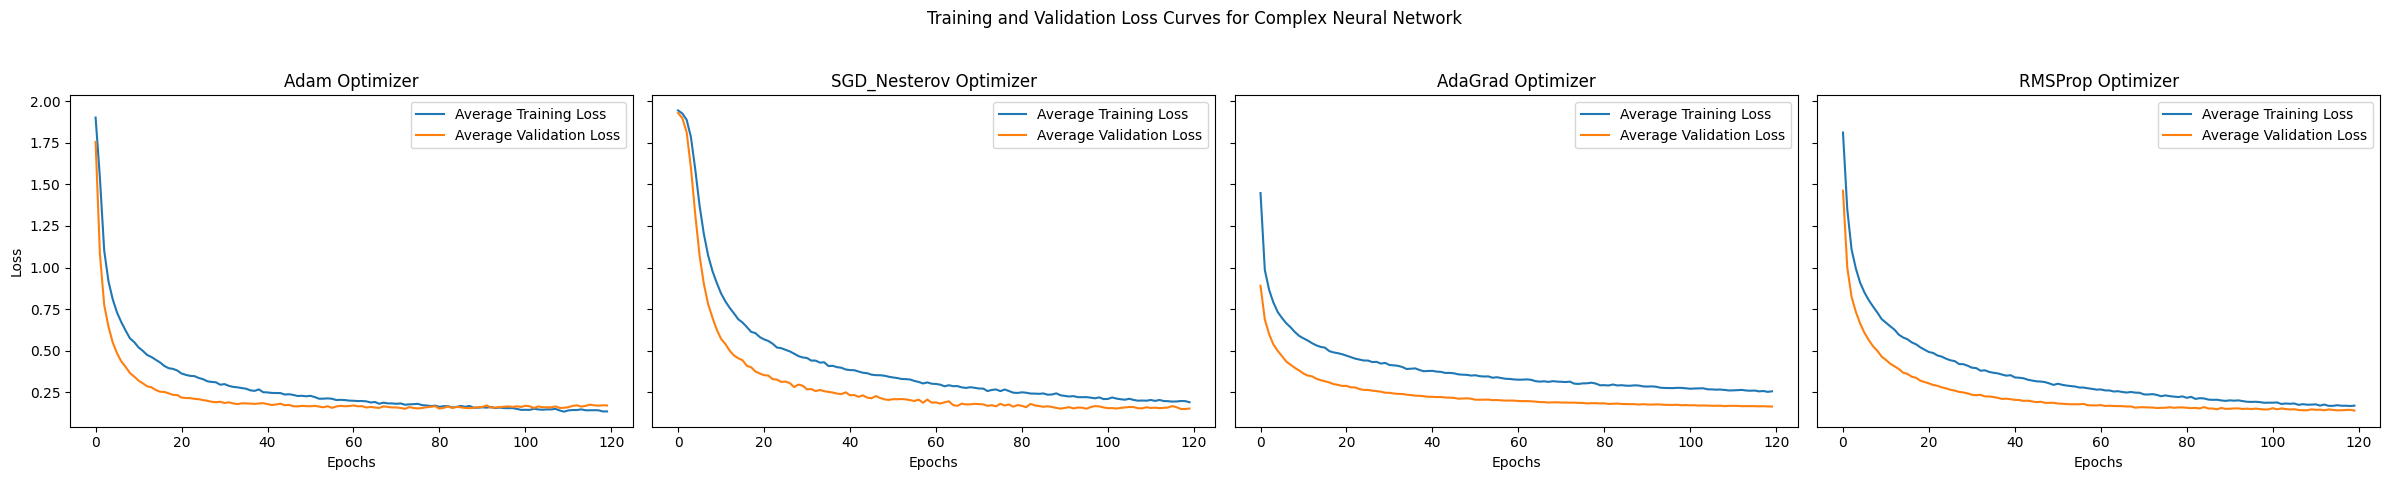

In [153]:
optimizers = {
    'Adam': (adam_factory, adam_grid),
    'SGD_Nesterov': (sgd_nesterov_factory, sgd_grid),
    'AdaGrad': (adagrad_factory, adagrad_grid),
    'RMSProp': (rmsprop_factory, rmsprop_grid)
}

all_avg_accuracies = {}
for model_name, model_factory in models.items():
    optimizer_losses = {}
    avg_accuracies = {}
    for opt_name, (opt_factory, opt_grid) in tqdm(optimizers.items()):
        print(f"\nRunning grid search for {model_name} with {opt_name}")
        
        # Perform grid search
        best_params, best_accuracy = grid_search_optimizer(
            model_factory, opt_factory, opt_grid, X_filtered, y_filtered, k_folds=5, epochs=120
        )
        print(f"Best parameters for {model_name} using {opt_name}: {best_params}, Best Accuracy: {best_accuracy}%")

        # Train with best parameters
        optimized_optimizer_factory = lambda model: opt_factory(model, **best_params)
        print(f"\nTraining {model_name} with {opt_name} using best parameters")
        avg_accuracy, all_train_losses, all_val_losses = perform_cross_validation(
            model_factory, optimized_optimizer_factory, X_filtered, y_filtered, k_folds=10, epochs=120
        )

        # Collect losses for plotting
        optimizer_losses[opt_name] = (all_train_losses, all_val_losses)
        avg_accuracies[opt_name] = avg_accuracy
        
        print(f'Average Cross-Validation Accuracy: {round(avg_accuracy, 2)}%')  
    # Plot losses for all optimizers of the current model
    plot_optimizer_losses(model_name, optimizer_losses, save=True)
    all_avg_accuracies[model_name] = avg_accuracies